In [2]:
%load_ext autoreload
%autoreload 2


import argparse
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob

from dcase_models.model.container import *
from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.features import MelSpectrogram
from dcase_models.data.datasets import UrbanSound8k
from dcase_models.util.files import load_json, mkdir_if_not_exists, save_pickle, load_pickle
from dcase_models.util.data import evaluation_setup

sys.path.append('../')
from apnet.model import *
from apnet.layers import PrototypeLayer, WeightedSum, WeightedSumDistances

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset_name = 'UrbanSound8k'
model_name = 'APNet_4096'
features_name = 'MelSpectrogram'
fold_name = 'fold1'

In [4]:
# Get parameters
exp_path = '../experiments'
parameters_file_name = 'params_'+ dataset_name +'.json'
parameters_file = os.path.join(exp_path, parameters_file_name)
params = load_json(parameters_file)
params_dataset = params['datasets'][dataset_name]
params_features = params['features'][features_name]
params_model = params['models']['APNet']

In [5]:
dataset_path = os.path.join(exp_path, params_dataset['dataset_path'])
dataset = UrbanSound8k(dataset_path)
dataset.check_if_downloaded()

True

In [6]:
features = MelSpectrogram(**params_features)
features.check_if_extracted(dataset)

True

In [7]:
exp_folder = os.path.join(exp_path, model_name, dataset_name, fold_name)
scaler = load_pickle(os.path.join(exp_folder, 'scaler.pickle'))

model_container = APNet(
    model=None, model_path=exp_folder, 
    custom_objects={
        'PrototypeLayer': PrototypeLayer,
        'WeightedSum': WeightedSum,
        'WeightedSumDistances': WeightedSumDistances
    },
    metrics=['classification'],
    **params['models']['APNet']['model_arguments']
)
model_container.load_model_weights(exp_folder)
model_container.model.summary()

(50, 32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 84, 128)      0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 21, 32, 32), 52096       input[0][0]                      
__________________________________________________________________________________________________
features (Lambda)               (None, 21, 32, 32)   0           encoder[1][0]                    
__________________________________________________________________________________________________
prototype_distances (PrototypeL (None, 50, 21, 32)   1075200     features[0][0]                   
__________________________________________________________________________________________________
p

In [8]:
folds_train, folds_val, _ = evaluation_setup(
    fold_name, dataset.fold_list,
    params_dataset['evaluation_mode'],
    use_validate_set=True
)
data_gen = DataGenerator(
    dataset, features, folds=folds_train,
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)

In [9]:
X, Y = data_gen.get_data()

In [11]:
model_container.get_prototypes(X)
model_container.update_model_to_prototypes()

Getting prototypes (spectrograms)...
Done!
Converting to audio...
Done!
euclidean_patches 1
(50, 32)


In [13]:
weights = model_container.model.get_layer('mean').get_weights()[0]
print(weights.shape)

(50, 32)


In [ ]:
print()

In [ ]:
X = (X + 1) /2

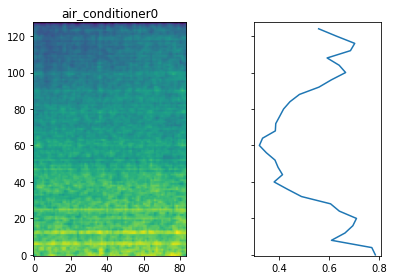

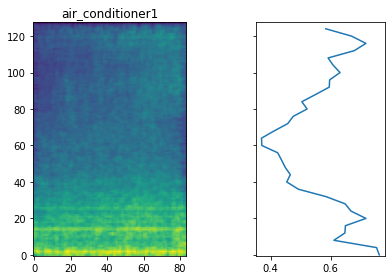

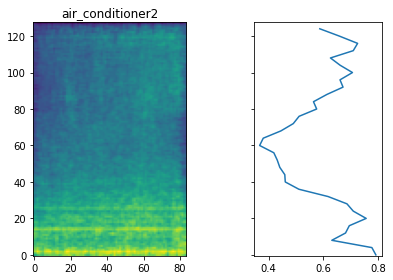

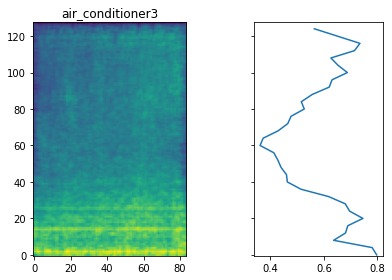

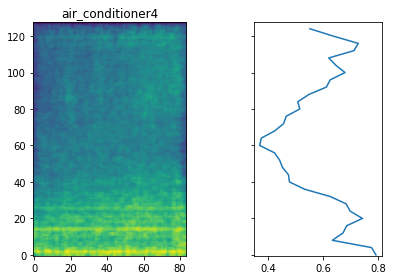

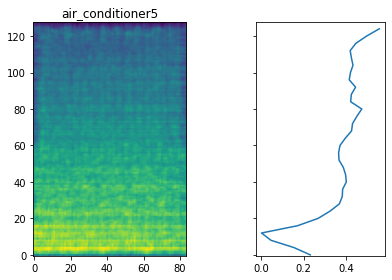

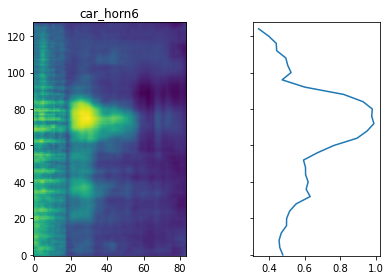

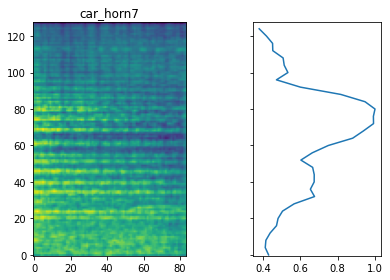

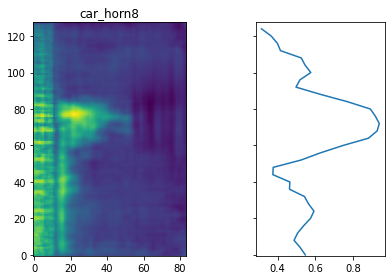

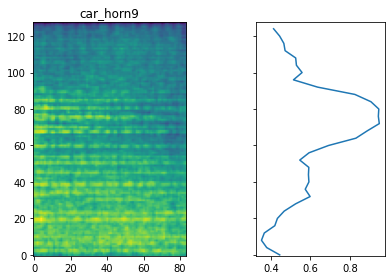

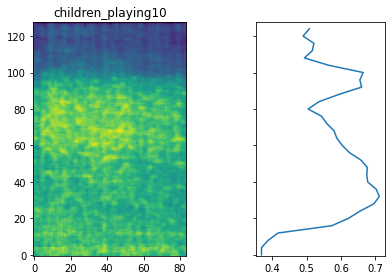

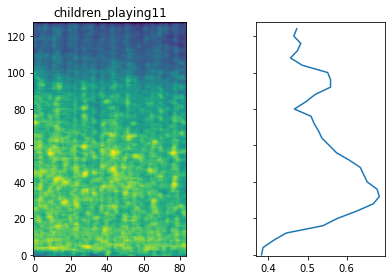

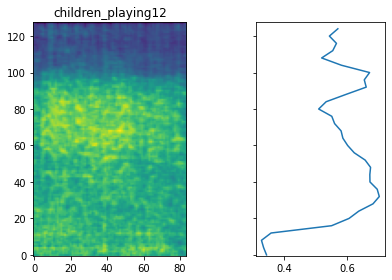

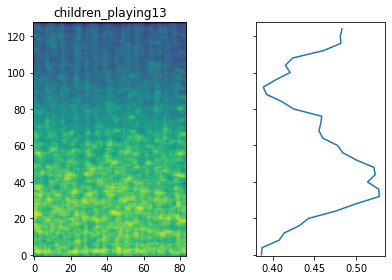

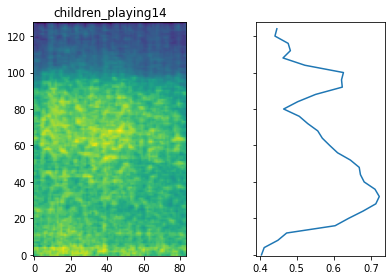

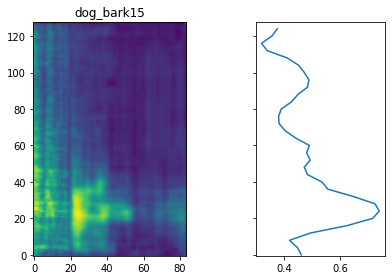

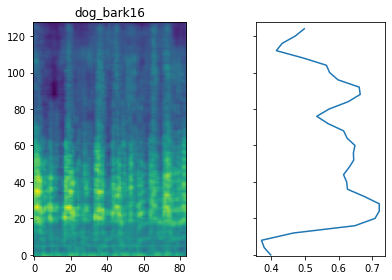

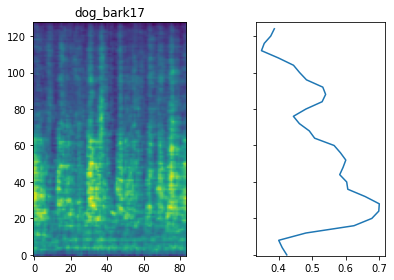

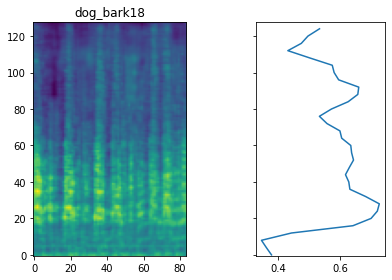

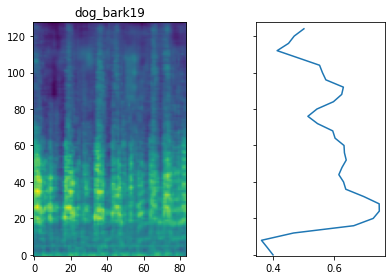

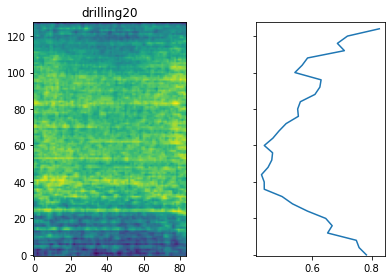

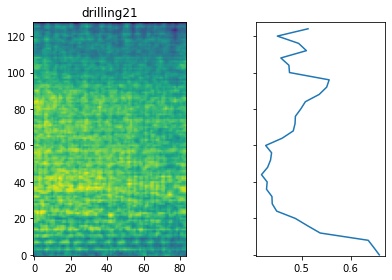

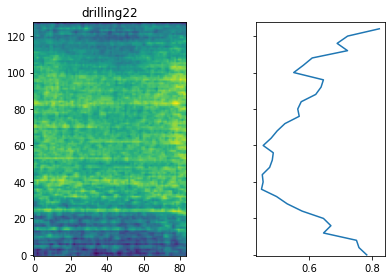

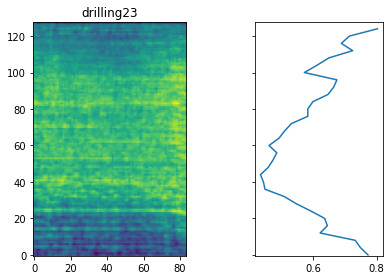

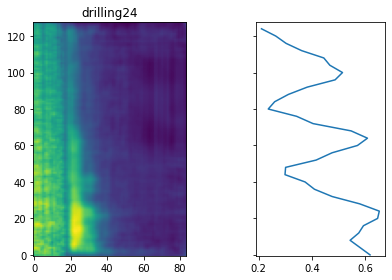

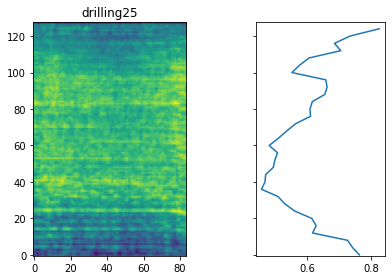

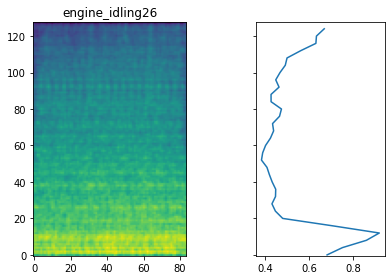

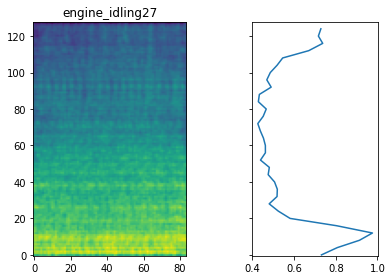

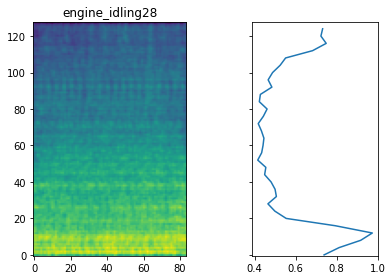

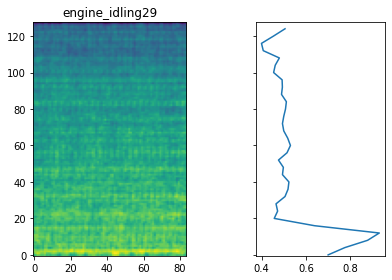

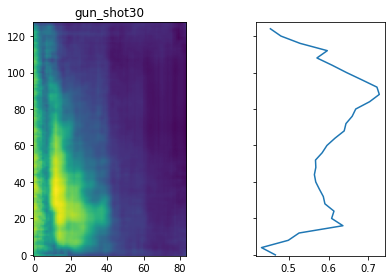

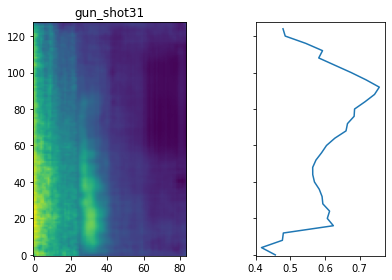

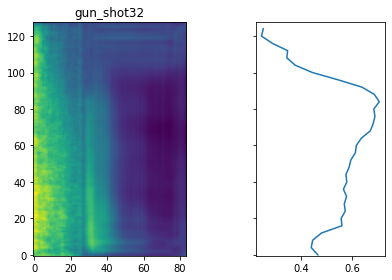

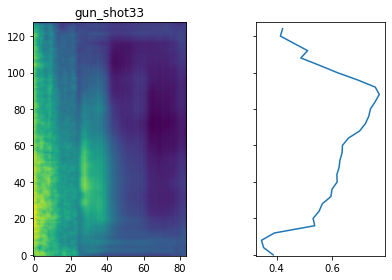

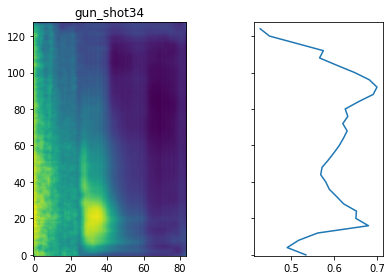

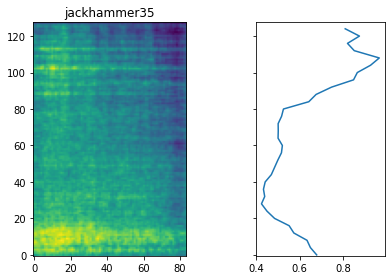

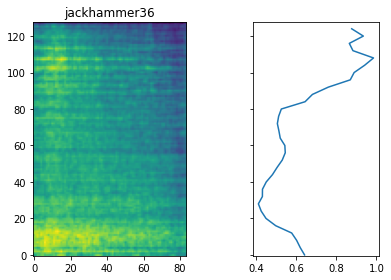

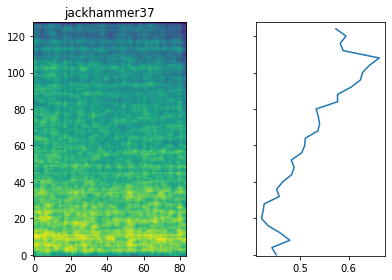

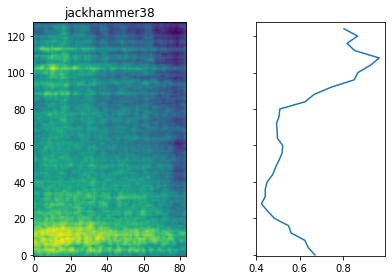

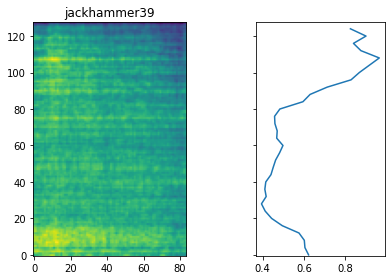

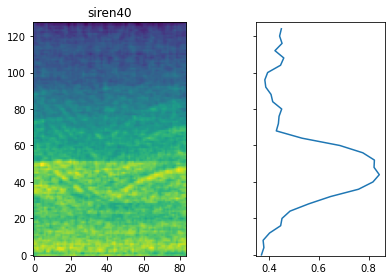

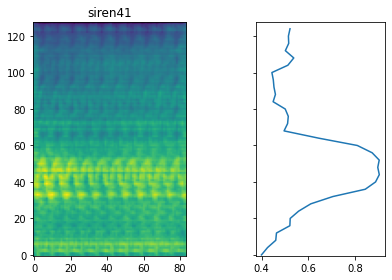

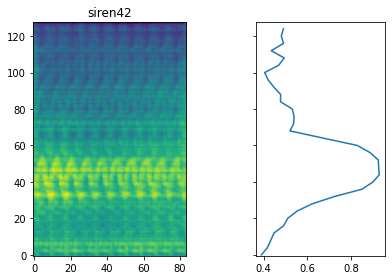

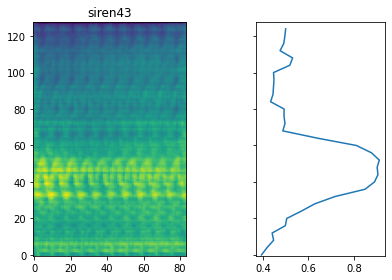

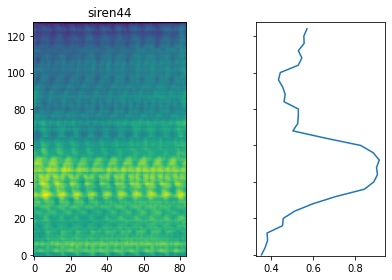

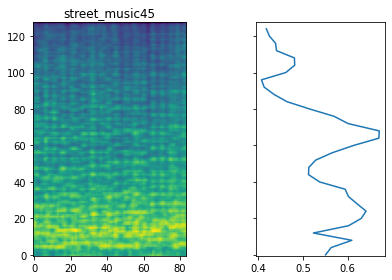

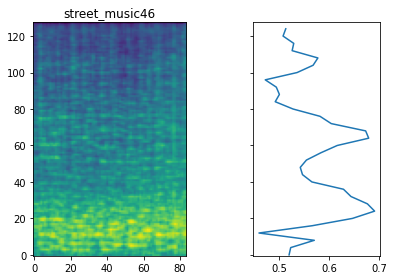

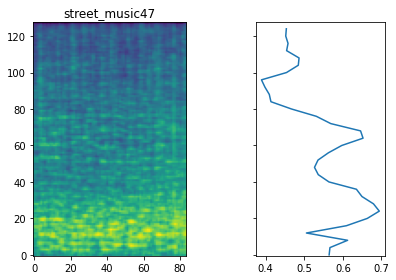

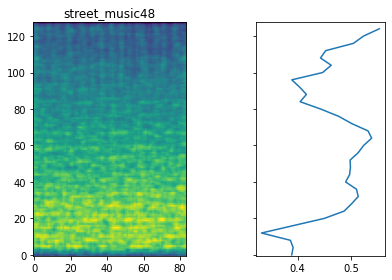

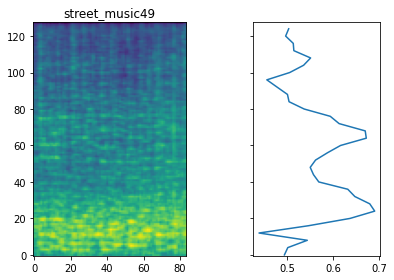

In [31]:
#ann = np.argmax(Y, axis=1)
from scipy import interpolate

for j in range(50):
   # plt.subplot(1,3,1)
    
    latent = (weights[j]-np.amin(weights))/(np.amax(weights)- np.amin(weights))
    latent_index = np.arange(32)
   # plt.plot(latent_index*4, latent)
   # plt.title(dataset.label_list[model_container.prototypes.classes[j]])
    
   # plt.subplot(1,3,2)
    
    
    f = interpolate.interp1d((latent_index)*4, latent)
    xnew = np.arange(124)
    ynew = f(xnew) 
    #plt.plot(ynew)
    #plt.subplot(1,3,3)
    class_ix = model_container.prototypes.classes[j]

    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(1, 3)
    ax1 = fig.add_subplot(gs[0, 0:2])
    ax2 = fig.add_subplot(gs[0, 2], sharey=ax1)
    plt.setp(ax2.get_yticklabels(), visible=False)
    ax1.imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
    ax2.plot(latent,latent_index*4)
    ax1.set_title(dataset.label_list[model_container.prototypes.classes[j]]+str(j))
    

   # plt.imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
    
    #sum_energy = np.sum(X[ann==class_ix], axis=(0,1))
    #sum_energy_conv = np.ones(32)
    #for j in range(32):
        #print(j*4-16,j*4+16)
        #sum_energy_conv[j] = np.sum(sum_energy[j*4-16:j*4+16])
    #plt.plot(sum_energy)
    plt.tight_layout()
    plt.show()
    #break
    
    l = [7, 19, 29, 38, 40]
    

GridSpec(1, 4)


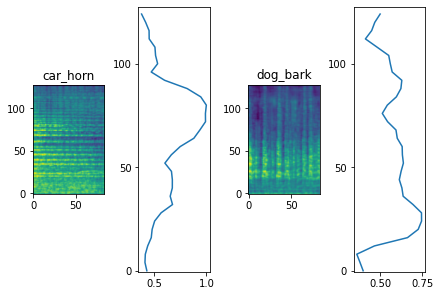

In [55]:
list_protos = [7, 19]#, 19, 29, 38, 40]

fig = plt.figure(figsize=(14,8), constrained_layout=True)

gs = fig.add_gridspec(1, len(list_protos)*2)
print(gs)
#plt.subplots(1, len(list_protos)*2, sharey=True)
for ix, j in enumerate(list_protos):
    latent = (weights[j]-np.amin(weights))/(np.amax(weights)- np.amin(weights))
    latent_index = np.arange(32)
    
    if ix == 0:
        ax0 = fig.add_subplot(gs[0, ix])

        ax0.imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
        ax0.set_title(dataset.label_list[model_container.prototypes.classes[j]])
    else:
        ax= fig.add_subplot(gs[0, ix*2], sharey=ax0)
        ax.imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
        ax.set_title(dataset.label_list[model_container.prototypes.classes[j]])    
    
    ax = fig.add_subplot(gs[0, ix*2+1], sharey=ax0)
    ax.plot(latent,latent_index*4)

plt.show()

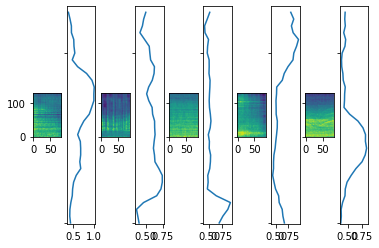

In [64]:
list_protos = [7, 19, 29, 38, 40]

fig, axes = plt.subplots(ncols=10, sharey=True)

for ix, j in enumerate(list_protos):
    latent = (weights[j]-np.amin(weights))/(np.amax(weights)- np.amin(weights))
    latent_index = np.arange(32)
    
    axes[2*ix].imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
    #axes[2*ix].set_title(dataset.label_list[model_container.prototypes.classes[j]])
    
    
    axes[2*ix+1].plot(latent,latent_index*4)
#plt.setp(axes, title='Test')
#fig.suptitle('An overall title', size=20)

#fig.tight_layout()
#fig.subplots_adjust(top=0.9) 

plt.show()

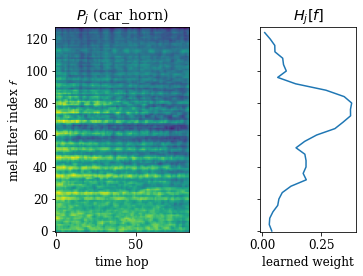

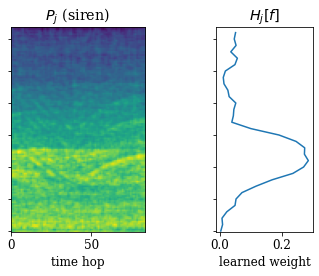

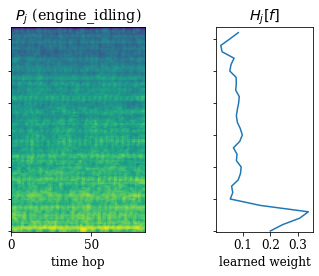

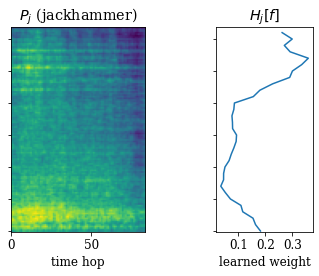

In [116]:
import matplotlib.gridspec as gridspec
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

list_protos = [7, 40, 29, 38]

for ix, j in enumerate(list_protos):
    latent = weights[j] #(weights[j]-np.amin(weights))/(np.amax(weights)- np.amin(weights))
    latent_index = np.arange(32)
    
    fig = plt.figure(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, width_ratios=[1, 0.3])
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1], sharey=ax1)
    #ax3 = fig.add_subplot(gs[0,2], sharey=ax1)
    #ax4 = fig.add_subplot(gs[0,3], sharey=ax1)

    ax1.imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
    ax1.set_title('$P_j $' + ' (' + dataset.label_list[model_container.prototypes.classes[j]] + ')')
    
    ax1.set_xlabel('time hop')
    if ix != 0:
        plt.setp(ax1.get_yticklabels(), visible=False)
    else:
        ax1.set_ylabel('mel filter index $\mathcal{f}$')
    #ax3.imshow(model_container.prototypes.mel_spectrograms[j].T, origin='lower')
    ax2.plot(latent,latent_index*4)
    ax2.set_title('$H_j[f]$')
    ax2.set_xlabel('learned weight')
    plt.setp(ax2.get_yticklabels(), visible=False)

    #ax4.plot(latent,latent_index*4)
    
    plt.tight_layout()
    plt.savefig('images/weighted_sum' + str(ix) + '.png', dpi=300, bbox_inches='tight')#, pad_inches=0)
    plt.show()

In [117]:
from PIL import Image

images = [Image.open(x) for x in ['weighted_sum0.png', 'weighted_sum1.png', 'weighted_sum2.png', 'weighted_sum3.png']]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in images:
  new_im.paste(im, (x_offset,0))
  x_offset += im.size[0]

new_im.save('images/weighted_sum.png')